In [3]:
#use "topfind"
#require "owl-jupyter"
open Owl_jupyter
open Owl

Raised at Stdlib.invalid_arg in file "stdlib.ml", line 30, characters 20-45
Called from Toploop in file "toplevel/toploop.ml", line 516, characters 2-159
Called from Topdirs.load_compunit in file "toplevel/topdirs.ml", line 153, characters 11-23

- : unit = ()
Findlib has been successfully loaded. Additional directives:
  #require "package";;      to load a package
  #list;;                   to list the available packages
  #camlp4o;;                to load camlp4 (standard syntax)
  #camlp4r;;                to load camlp4 (revised syntax)
  #predicates "p,q,...";;   to set these predicates
  Topfind.reset();;         to force that packages will be reloaded
  #thread;;                 to enable threads

- : unit = ()


In [18]:
let d =
  let _eps = 0.1 in
  let diff f x = (f (x +. _eps) -. f x) /. _eps in
  diff Maths.cos 1.
;;

val d : float = -0.867061844425624506


In [19]:
let d =
  let _eps = 5E-16 in
  let diff f x = (f (x +. _eps) -. f x) /. _eps in
  diff Maths.cos 1.
;;

val d : float = -0.666133814775093924


In [22]:
open Algodiff.D;;
let f x =
  let x1 = Mat.get x 0 0 in
  let x2 = Mat.get x 0 1 in
  Maths.(div (F 1.) (F 1. + exp (x1 * x2 + (sin x1))))
;;
let x = Mat.ones 1 2;;
let _ = grad f x |> unpack_arr;;

val f : Owl_algodiff.D.t -> Owl_algodiff.D.t = <fun>


val x : Owl_algodiff.D.t = [Arr(1,2)]


- : Owl.Algodiff.D.A.arr = 
          C0        C1 
R0 -0.181974 -0.118142 



In [23]:
module D = Owl_numdiff_generic.Make (Dense.Ndarray.D);;

module D :
  sig
    type arr = Owl.Dense.Ndarray.D.arr
    type elt = Owl.Dense.Ndarray.D.elt
    val _eps : float
    val _ep1 : float
    val _ep2 : float
    val diff : (float -> float) -> float -> float
    val diff' : (float -> float) -> float -> float * float
    val diff2 : (float -> float) -> float -> float
    val diff2' : (float -> float) -> float -> float * float
    val grad' :
      (Owl.Dense.Ndarray.D.arr -> Owl.Dense.Ndarray.D.elt) ->
      Owl.Dense.Ndarray.D.arr ->
      Owl.Dense.Ndarray.D.arr * Owl.Dense.Ndarray.D.arr
    val grad :
      (Owl.Dense.Ndarray.D.arr -> Owl.Dense.Ndarray.D.elt) ->
      Owl.Dense.Ndarray.D.arr -> Owl.Dense.Ndarray.D.arr
    val jacobianT' :
      (Owl.Dense.Ndarray.D.arr -> Owl.Dense.Ndarray.D.arr) ->
      Owl.Dense.Ndarray.D.arr ->
      Owl.Dense.Ndarray.D.arr * Owl.Dense.Ndarray.D.arr
    val jacobianT :
      (Owl.Dense.Ndarray.D.arr -> Owl.Dense.Ndarray.D.arr) ->
      Owl.Dense.Ndarray.D.arr -> Owl.Dense.Ndarray.D.arr
    val ja

In [30]:
let x = Arr.ones [|2|]

val x : Owl.Arr.arr = 
  C0 C1 
R  1  1 



In [33]:
let f x =
    let x1 = Arr.get x [|0|] in
    let x2 = Arr.get x [|1|] in
    Maths.(div 1. (1. +. exp (x1 *. x2 +. (sin x1))))

val f : Owl.Arr.arr -> float = <fun>


In [34]:
D.grad f x;;

- : Owl.Dense.Ndarray.D.arr = 
         C0        C1 
R -0.181973 -0.118142 



In [35]:
type df = {
    mutable p: float;
    mutable t: float
}

let primal df = df.p
let tangent df = df.t

type df = { mutable p : float; mutable t : float; }


val primal : df -> float = <fun>


val tangent : df -> float = <fun>


In [36]:
let sin_ad x =
    let p = primal x in
    let t = tangent x in
    let p' = Owl_maths.sin p in
    let t' = (Owl_maths.cos p) *. t in
    {p=p'; t=t'}

val sin_ad : df -> df = <fun>


In [37]:
let exp_ad x =
    let p = primal x in
    let t = tangent x in
    let p' = Owl_maths.exp p in
    let t' = p' *. t in
    {p=p'; t=t'}

val exp_ad : df -> df = <fun>


In [38]:
let mul_ad a b =
    let pa = primal a in
    let ta = tangent a in
    let pb = primal b in
    let tb = tangent b in
    let p' = pa *. pb in
    let t' = pa *. tb +. ta *. pb in
    {p=p'; t=t'}

val mul_ad : df -> df -> df = <fun>


In [39]:
let add_ad a b =
    let pa = primal a in
    let ta = tangent a in
    let pb = primal b in
    let tb = tangent b in
    let p' = pa +. pb in
    let t' = ta +. tb in
    {p=p'; t=t'}

let div_ad a b =
    let pa = primal a in
    let ta = tangent a in
    let pb = primal b in
    let tb = tangent b in
    let p' = pa /. pb in
    let t' = (ta *. pb -. tb *. pa) /. (pb *. pb) in
    {p=p'; t=t'}

val add_ad : df -> df -> df = <fun>


val div_ad : df -> df -> df = <fun>


In [40]:
let diff f =
  let f' x y =
    let r = f x y in
    primal r, tangent r
  in
  f'

val diff : ('a -> 'b -> df) -> 'a -> 'b -> float * float = <fun>


In [41]:
let x0 = {p=1.; t=1.}
let x1 = {p=1.; t=0.}

val x0 : df = {p = 1.; t = 1.}


val x1 : df = {p = 1.; t = 0.}


In [42]:
let f x0 x1 =
  let v2 = sin_ad x0 in
  let v3 = mul_ad x0 x1 in
  let v4 = add_ad v2 v3 in
  let v5 = {p=1.; t=0.} in
  let v6 = exp_ad v4 in
  let v7 = {p=1.; t=0.} in
  let v8 = add_ad v5 v6 in
  let v9 = div_ad v7 v8 in
  v9
;;

val f : df -> df -> df = <fun>


In [43]:
let pri, tan = diff f x0 x1;;

val pri : float = 0.13687741466075895
val tan : float = -0.181974376561731321


In [44]:
type dr = {
    mutable p: float;
    mutable a: float ref;
  mutable adj_fun : float ref -> (float * dr) list -> (float * dr) list
}

let primal dr = dr.p
let adjoint dr = dr.a
let adj_fun dr = dr.adj_fun

type dr = {
  mutable p : float;
  mutable a : float ref;
  mutable adj_fun : float ref -> (float * dr) list -> (float * dr) list;
}


val primal : dr -> float = <fun>


val adjoint : dr -> float ref = <fun>


val adj_fun : dr -> float ref -> (float * dr) list -> (float * dr) list =
  <fun>


In [45]:
let sin_ad dr =
    let p = primal dr in
    let p' = Owl_maths.sin p in
    let adjfun' ca t =
        let r = !ca *. (Owl_maths.cos p) in
        (r, dr) :: t
    in
    {p=p'; a=ref 0.; adj_fun=adjfun'}

val sin_ad : dr -> dr = <fun>


In [46]:
let mul_ad dr1 dr2 =
    let p1 = primal dr1 in
    let p2 = primal dr2 in

    let p' = Owl_maths.mul p1 p2 in
    let adjfun' ca t =
        let r1 = !ca *. p2 in
        let r2 = !ca *. p1 in
        (r1, dr1) :: (r2, dr2) :: t
    in
    {p = p'; a = ref 0.; adj_fun = adjfun'}

val mul_ad : dr -> dr -> dr = <fun>


In [47]:
let make_reverse v =
    let a = ref 0. in
    let adj_fun _a t = t in
    {p=v; a; adj_fun}

val make_reverse : float -> dr = <fun>


In [49]:
let x = make_reverse 1.;;

val x : dr = {p = 1.; a = {contents = 0.}; adj_fun = <fun>}


In [50]:
let y = make_reverse 2.;;

val y : dr = {p = 2.; a = {contents = 0.}; adj_fun = <fun>}


In [51]:
let v = mul_ad (sin_ad x) y;;

val v : dr = {p = 1.68294196961579301; a = {contents = 0.}; adj_fun = <fun>}


In [52]:
let rec reverse_push xs =
    match xs with
    | [] -> ()
    | (v, dr) :: t ->
        let aa = adjoint dr in
        let adjfun = adj_fun dr in
        aa := !aa +. v;
        let stack = adjfun aa t in
        reverse_push stack

val reverse_push : (float * dr) list -> unit = <fun>


In [53]:
let exp_ad dr =
    let p = primal dr in
    let p' = Owl_maths.exp p in
    let adjfun' ca t =
        let r = !ca *. (Owl_maths.exp p) in
        (r, dr) :: t
    in
    {p=p'; a=ref 0.; adj_fun=adjfun'}


let add_ad dr1 dr2 =
    let p1 = primal dr1 in
    let p2 = primal dr2 in
    let p' = Owl_maths.add p1 p2 in
    let adjfun' ca t =
        let r1 = !ca in
        let r2 = !ca in
        (r1, dr1) :: (r2, dr2) :: t
    in
    {p = p'; a = ref 0.; adj_fun = adjfun'}


let div_ad dr1 dr2 =
    let p1 = primal dr1 in
    let p2 = primal dr2 in

    let p' = Owl_maths.div p1 p2 in
    let adjfun' ca t =
        let r1 = !ca /. p2 in
        let r2 = !ca *. (-.p1) /. (p2 *. p2) in
        (r1, dr1) :: (r2, dr2) :: t
    in
    {p = p'; a = ref 0.; adj_fun = adjfun'}

val exp_ad : dr -> dr = <fun>


val add_ad : dr -> dr -> dr = <fun>


val div_ad : dr -> dr -> dr = <fun>


In [54]:
let diff f =
  let f' x =
    (* forward pass *)
    let r = f x in
    (* backward pass *)
    reverse_push [(1., r)];
    (* get result values *)
    let x0, x1 = x in
    primal x0, !(adjoint x0), primal x1, !(adjoint x1)
  in
  f'

val diff : (dr * dr -> dr) -> dr * dr -> float * float * float * float =
  <fun>


In [55]:
let x1 = make_reverse 1.;;

val x1 : dr = {p = 1.; a = {contents = 0.}; adj_fun = <fun>}


In [56]:
let x0 = make_reverse 1.;;

val x0 : dr = {p = 1.; a = {contents = 0.}; adj_fun = <fun>}


In [57]:
let f x =
  let x0, x1 = x in
  let v2 = sin_ad x0 in
  let v3 = mul_ad x0 x1 in
  let v4 = add_ad v2 v3 in
  let v5 = make_reverse 1. in
  let v6 = exp_ad v4 in
  let v7 = make_reverse 1. in
  let v8 = add_ad v5 v6 in
  let v9 = div_ad v7 v8 in
  v9
;;


val f : dr * dr -> dr = <fun>


In [58]:
let pri_x0, adj_x0, pri_x1, adj_x1 = diff f (x0, x1);;

val pri_x0 : float = 1.
val adj_x0 : float = -0.181974376561731321
val pri_x1 : float = 1.
val adj_x1 : float = -0.118141988016545588


In [59]:
open Algodiff.D

let f0 x = Maths.(tanh x)
let d = diff f0 (F 0.1)

val f0 : Owl_algodiff.D.t -> Owl_algodiff.D.t = <fun>


val d : Owl.Algodiff.D.t = [F(0.990066)]


In [60]:
let f0 x = Maths.(tanh x);;
let f1 = diff f0;;
let f2 = diff f1;;
let f3 = diff f2;;
let f4 = diff f3;;

val f0 : Owl_algodiff.D.t -> Owl_algodiff.D.t = <fun>


val f1 : Owl.Algodiff.D.t -> Owl.Algodiff.D.t = <fun>


val f2 : Owl.Algodiff.D.t -> Owl.Algodiff.D.t = <fun>


val f3 : Owl.Algodiff.D.t -> Owl.Algodiff.D.t = <fun>


val f4 : Owl.Algodiff.D.t -> Owl.Algodiff.D.t = <fun>


val map :
  (Owl.Algodiff.D.t -> Owl.Algodiff.D.t) -> Owl.Mat.mat -> Owl.Mat.mat =
  <fun>


val x : Owl.Mat.mat =
  
   C0      C1      C2      C3      C4       C195   C196   C197   C198 C199 
R0 -4 -3.9598 -3.9196 -3.8794 -3.8392 ... 3.8392 3.8794 3.9196 3.9598    4 



val y0 : Owl.Mat.mat =
  
          C0        C1        C2        C3        C4         C195     C196     C197     C198     C199 
R0 -0.999329 -0.999273 -0.999212 -0.999146 -0.999075 ... 0.999075 0.999146 0.999212 0.999273 0.999329 



val y1 : Owl.Mat.mat =
  
           C0         C1        C2         C3         C4           C195       C196      C197       C198       C199 
R0 0.00134095 0.00145314 0.0015747 0.00170643 0.00184916 ... 0.00184916 0.00170643 0.0015747 0.00145314 0.00134095 



val y2 : Owl.Mat.mat =
  
          C0         C1         C2         C3        C4           C195        C196        C197        C198       C199 
R0 0.0026801 0.00290416 0.00314692 0.00340994 0.0036949 ... -0.0036949 -0.00340994 -0.00314692 -0.00290416 -0.0026801 



val y3 : Owl.Mat.mat =
  
           C0         C1         C2         C3         C4           C195       C196       C197       C198       C199 
R0 0.00535301 0.00579988 0.00628393 0.00680824 0.00737613 ... 0.00737613 0.00680824 0.00628393 0.00579988 0.00535301 



val y4 : Owl.Mat.mat =
  
          C0       C1        C2        C3        C4           C195       C196       C197      C198       C199 
R0 0.0106773 0.011566 0.0125282 0.0135699 0.0146976 ... -0.0146976 -0.0135699 -0.0125282 -0.011566 -0.0106773 



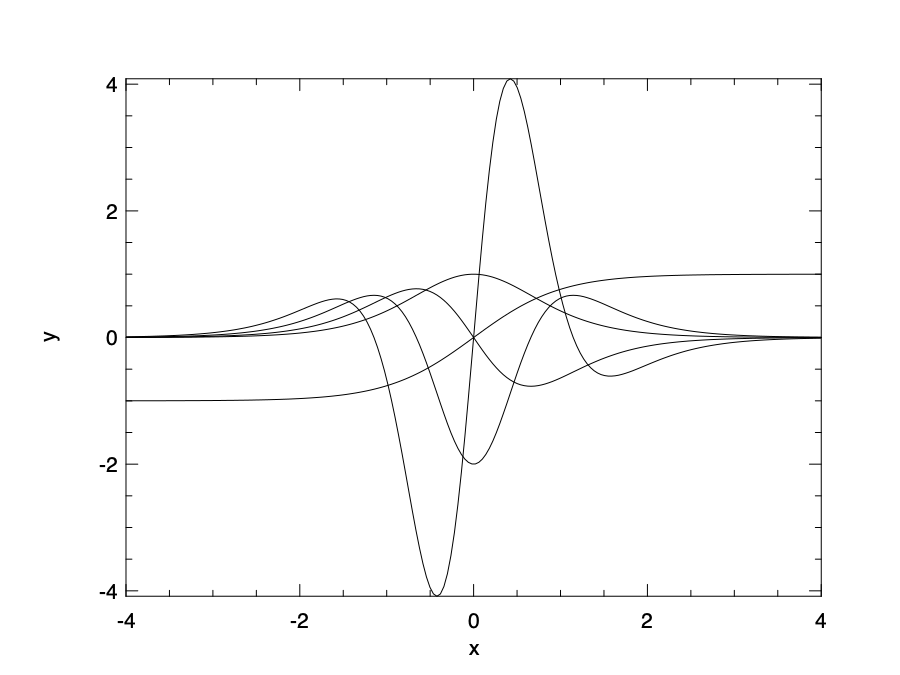

- : unit = ()


In [61]:
let map f x = Owl.Mat.map (fun a -> a |> pack_flt |> f |> unpack_flt) x;;

let x = Owl.Mat.linspace (-4.) 4. 200;;
let y0 = map f0 x;;
let y1 = map f1 x;;
let y2 = map f2 x;;
let y3 = map f3 x;;
let y4 = map f4 x;;

let h = Plot.create "plot_00.png" in
Plot.plot ~h x y0;
Plot.plot ~h x y1;
Plot.plot ~h x y2;
Plot.plot ~h x y3;
Plot.plot ~h x y4;
Plot.output h;;

In [69]:
#require "owl-plplot"

In [70]:
let generate_data () =
  let x = Mat.uniform 1000 3 in
  let p = Mat.uniform 3 2 in
  let y = Mat.(x *@ p) in
  x, p, y

val generate_data :
  unit ->
  Owl.Mat.mat * Owl.Mat.mat *
  (float, Bigarray.float64_elt) Owl_dense_matrix_generic.t = <fun>


In [73]:
let test_ols () =
  let x, p, y = generate_data () in
  let r = Regression.D.ols ~i:false x y in
  Mat.(p - r.(0) |> print)


let test_lasso () =
  let x, p, y = generate_data () in
  let r = Regression.D.lasso ~i:false x y in
  Mat.(p - r.(0) |> print)


let test_ridge () =
  let x, p, y = generate_data () in
  let r = Regression.D.ridge ~i:true x y in
  Mat.(p - r.(0) |> print)


let test_elastic () =
  let x, p, y = generate_data () in
  let r = Regression.D.elastic_net ~i:true x y in
  Mat.(p - r.(0) |> print)


let test_exp () =
  let x = Mat.uniform 50 1 in
  let a = 0.25 in
  let l = 0.55 in
  let b = 0.79 in
  let y = Mat.((a $* exp (-.l $* x)) +$ b) in
  let a', l', b' = Regression.D.exponential x y in
  Printf.printf "(%g, %g, %g) (%g, %g, %g)\n" a l b a' l' b'

val test_ols : unit -> unit = <fun>


val test_lasso : unit -> unit = <fun>


val test_ridge : unit -> unit = <fun>


val test_elastic : unit -> unit = <fun>


val test_exp : unit -> unit = <fun>


In [77]:
let _ =
  Owl_log.info "test exp"; test_exp (); flush_all ();
  Owl_log.info "test ols"; test_ols (); flush_all ();
  Owl_log.info "test lasso"; test_lasso (); flush_all ();
  Owl_log.info "test ridge"; test_ridge (); flush_all ();
  Owl_log.info "test elastic"; test_elastic (); flush_all ();


2021-04-10 07:09:17.571 INFO : test exp
(0.25, 0.55, 0.79) (-1.25628e-31, 5.38026e-17, 0.978916)
2021-04-10 07:09:18.551 INFO : test ols


             C0           C1 
R0 -2.22045E-16 -2.77556E-16 
R1  4.44089E-16  1.11022E-16 
R2 -2.22045E-16  2.22045E-16 
2021-04-10 07:09:19.040 INFO : test lasso


            C0          C1 
R0 5.78241E-07 5.78241E-07 
R1 5.39485E-07 5.39485E-07 
R2 7.07657E-07 7.07657E-07 
2021-04-10 07:09:19.458 INFO : test ridge


            C0          C1 
R0 1.93851E-06 1.60414E-06 
R1 2.57923E-07 4.07721E-06 
R2 1.04331E-06 3.47282E-06 
2021-04-10 07:09:19.874 INFO : test elastic


           C0         C1 
R0 0.00225723 0.00163664 
R1 0.00205793 0.00237668 
R2 0.00164073 0.00166343 


- : unit = ()


In [7]:
open Algodiff.D
let f x = Maths.(x ** (F 2.) - (F 2.))

let _ =
    let x = ref 1. in
    for _ = 0 to 6 do
        let g = diff f (F !x) |> unpack_elt in
        let v = f (F !x) |> unpack_elt in
        x := !x -. v /. g;
        Printf.printf "%.15f\n" !x;
    done;

val f : Owl_algodiff.D.t -> Owl_algodiff.D.t = <fun>


- : unit = ()


In [8]:
try 
let s = StrSet.empty in 
    print_string (StrSet.max_elt s) 
with Not_found -> print_endline "\nSet s is empty!";;

error: compile_error